In [ ]:
!pip install --upgrade diffusers[torch]
!pip install diffusers
!pip install transformers
!pip install torch

In [1]:
import os
from pathlib import Path

In [2]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA

In [3]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

2025-12-04 00:34:34.038830: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-04 00:34:34.038884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-04 00:34:34.040295: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-04 00:34:34.046841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def get_all_images_pathlib(root_folder):
    root_path = Path(root_folder)
    images = []
    
    for file_path in root_path.rglob('*'):
        if file_path.suffix.lower() == '.jpg':
            images.append(str(file_path))
    
    return images

In [5]:
base_dir = '/home/nbohra/'
animals_folder = f'{base_dir}COGS118B_FinalProject/Animals'
root_path = Path(animals_folder)

# Check if folder exists
print(f"Does folder exist? {root_path.exists()}")
print(f"Is it a directory? {root_path.is_dir()}")


Does folder exist? True
Is it a directory? True


In [6]:
animals_folder = f'{base_dir}COGS118B_FinalProject/Animals'
animals = get_all_images_pathlib(animals_folder)

print(f"Found {len(animals)} images")
# for img in animals:
#     print(img)

Found 1923 images


In [7]:
birds_folder = f'{base_dir}COGS118B_FinalProject/Birds'
birds = get_all_images_pathlib(birds_folder)

print(f"Found {len(birds)} images")
# for img in birds:
#     print(img)

Found 333 images


In [8]:
patterns_folder = f'{base_dir}COGS118B_FinalProject/Patterns'
patterns = get_all_images_pathlib(patterns_folder)
print(f"Found {len(patterns)} images")
# for img in patterns:
#     print(img)

Found 1380 images


## Helper functions and starter code given from COGS 118B staff

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
).to(device)

vision_encoder = pipe.image_encoder  

Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

In [11]:
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [12]:
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

In [13]:
# Sanity check on image embeddings

img_vec = embed_images([f"{base_dir}COGS118B_FinalProject/Animals/alpaca/alpaca_01b.jpg", # 1st img of alpaca
                       f"{base_dir}COGS118B_FinalProject/Animals/antelope/antelope_01b.jpg", # 1st img of antelope
                       f"{base_dir}COGS118B_FinalProject/Animals/blowfish/blowfish_01b.jpg"]) #1st img of blowfish
img_vec2 = embed_images([f"{base_dir}/COGS118B_FinalProject/Animals/alpaca/alpaca_02s.jpg", # 2nd img of alpaca
                       f"{base_dir}COGS118B_FinalProject/Animals/antelope/antelope_02n.jpg", #2nd img of antelope
                       f"{base_dir}COGS118B_FinalProject/Animals/blowfish/blowfish_02s.jpg"]) #2nd img of blowfish

sims = torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(img_vec2, dim=-1).T 
sims = sims.detach().cpu().numpy()

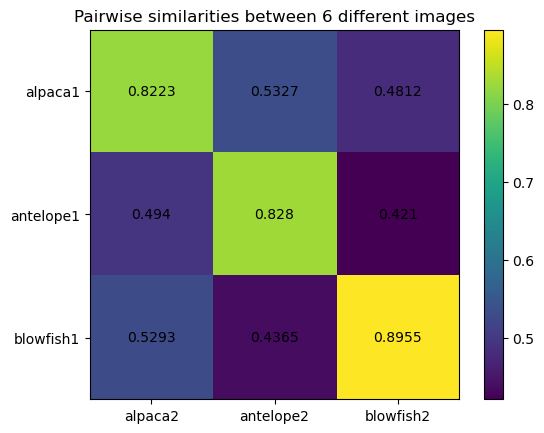

In [14]:
fig, ax = plt.subplots()

# Display the data as an image (heatmap)
im = ax.imshow(sims, cmap='viridis')

# Loop over the data and place text annotations
for i in range(sims.shape[0]):
    for j in range(sims.shape[1]):
        ax.text(j, i, sims[i, j], ha='center', va='center', color='black')

# Add a colorbar for reference
plt.colorbar(im)
plt.yticks([0, 1, 2], ['alpaca1', 'antelope1', 'blowfish1'])
plt.xticks([0, 1, 2], ['alpaca2', 'antelope2', 'blowfish2'])

# Set title and display the plot
ax.set_title('Pairwise similarities between 6 different images')
plt.show()

## Generating embeddings for each category of images.

In [15]:
# Run just once.
animals_emb = (embed_images(animals)).cpu().numpy()
birds_emb = (embed_images(birds)).cpu().numpy()
patterns_emb = (embed_images(patterns)).cpu().numpy()

In [16]:
# Checking the shape of embeddings to verify against dataset sizes 
print(f"Animals embeddings shape: {animals_emb.shape}")
print(f"Birds embeddings shape: {birds_emb.shape}")
print(f"Patterns embeddings shape: {patterns_emb.shape}")

Animals embeddings shape: (1923, 1024)
Birds embeddings shape: (333, 1024)
Patterns embeddings shape: (1380, 1024)


In [17]:
# Saving embeddings for each category to files for easier compute down the line
np.save('animals_emb.npy', animals_emb)
np.save('birds_emb.npy', birds_emb)
np.save('patterns_emb.npy', patterns_emb)

In [19]:
# TO LOAD
animals_emb = np.load('animals_emb.npy')
birds_emb = np.load('birds_emb.npy')
patterns_emb = np.load('patterns_emb.npy')

## Performing PCA on embedding data